In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from datetime import datetime
from nltk.corpus import stopwords
import nltk
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from collections import Counter
from nltk.util import ngrams
import html
import matplotlib.pyplot as plt

# libs for saving model
import pickle

# Plotting tools
import altair as alt
import pyLDAvis
import pyLDAvis.lda_model
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kalok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kalok\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kalok\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data cleaning ##

### process the special chars in the comment ###

It seems that the Reddit comment data are raw text data which means the HTML character entities are preserved. For example, we ofter encounter the following chars in the comment:

1. `&lt;` is an HTML entity for the less-than symbol ("<").
2. `&gt;` is an HTML entity for the greater-than symbol (">").

We need to convert these entities back to their original characters to ensure that the text is correctly interpreted and analyzed. This can usually be done using HTML parsing libraries.

Also, escape sequences such as `\n` and `\'` need to be replaced.

In [3]:
def remove_escape_seq(data):
    """
    """
    while data.body.str.contains('&gt;').sum() > 0:
        data['body'] = data['body'].apply(html.unescape)
        
    # Replace common escape sequences
    escape_sequences = {"\\n": " ", "\\r": " ", "\\t": " ", "\\'": "'", '\\"': '"', '\\b': '', '\\0': ''}
    for seq, replacement in escape_sequences.items():
        data['body'] = data['body'].str.replace(seq, replacement, regex=False)
    
    data['body'] = data.body.apply(lambda x: x.strip())

    return data

In [4]:
def convert_create_utc(data):
    """
    """
    # Ensure 'created_utc' is a datetime object
    data['created_utc'] = pd.to_datetime(data['created_utc'])
    return(data)

In [5]:
def aggregate_post_by_link_id(data) -> pd.Series:
    """
    """
    # Group by 'link_id', sort by 'created_utc', and concatenate 'body'
    grouped_texts = data.sort_values(by='created_utc').groupby('link_id')['body'].apply(lambda x: ' '.join(x)).reset_index()
    return grouped_texts

In [7]:
# testing function, or reduce noises
def combine_special_words(data):
    """
    """
    
    good_synonyms = {
    "nice": "good",
    "excellent": "good",
    "great": "good",
    "amazing": "good",
    "fantastic": "good",
    "awesome": "good",
    "wonderful": "good",
    "perfect": "good",
    "fabulous": "good",
    "superb": "good",
    "outstanding": "good",
    "beautiful": "good",
    "remarkable": "good",
    "impressive": "good",
    "splendid": "good",
    "terrific": "good",
    "marvelous": "good",
    "positive": "good",
    "satisfactory": "good",
    "pretty": "good",
    "pleasing": "good"}
    
    bad_synonyms = {
    "poor": "bad",
    "terrible": "bad",
    "awful": "bad",
    "horrible": "bad",
    "dreadful": "bad",
    "abysmal": "bad",
    "worse": "bad",
    "lousy": "bad",
    "atrocious": "bad",
    "inferior": "bad",
    "unsatisfactory": "bad",
    "inadequate": "bad",
    "substandard": "bad",
    "unsuitable": "bad",
    "unpleasant": "bad",
    "negative": "bad",
    "deficient": "bad",
    "mediocre": "bad",
    "pathetic": "bad",
    "lacking": "bad",
    "undesirable": "bad"}
    
    for seq, replacement in good_synonyms.items():
        data['body'] = data['body'].str.replace(seq, replacement, regex=False)
    data['body'] = data.body.apply(lambda x: x.strip())
    
    for seq, replacement in bad_synonyms.items():
        data['body'] = data['body'].str.replace(seq, replacement, regex=False)
    data['body'] = data.body.apply(lambda x: x.strip())

    return data

The codes of the following block is extending the stopwords list iteratively. During the fine-tuning, we try to identify words that are too common ("apple", "iphone", etc.), and then put them into the list, run the training again to check if any improvement.

In [10]:
stopwords = nltk.corpus.stopwords.words('english')

improved_sw_list = ['gonna', 'understand', 'seen', 'wanted', 'haha', 'max', 'restart', 'deleted', 'happening', 'possible', 'understand', 
                    'literally', 'matter', 'based', 'regarding', 'possible', 'latest', 'np', 'handed', 'iphone', 'use', 'people', 'http', 
                    'https', 'www', 'com', 'really', 'apple', 'actually', 'thanks', 'thank', 'think', 'phone', 'oh', 'sorry', 'hi', 'imgur', 
                    'like', 'get', 'got', 'used', 'make', 'work', 'worked', 'apps', 'want' 'wants', 'file', 'thing', 'say', 'know', 
                    'knew', 'reddit', 'subreddit', 'need', 'using', 'app', 'year', 'month', 'day', 'going', 'window', 'product', 'good', 
                    'pay', 'song', 'way', 'love', 'great', 'free', 'point', 'product', 'new', 'try', 'fix', 'work', 'issue', 'problem', 'got', 
                    'store', 'order', 'ordered', 'date', 'ship', 'shipping', 'org', 'usage', 'wikipedia', 'updates', 'update', 'feature', 
                    'gb', 'backup', 'file', 'space', 'lot', 'time', 'better', 'look', 'right', 'maybe', 'might', 'can', 'could', 'be', 'come', 
                    'device', 'user', 'run', 'nice', 'version', 'buy', 'software', 'hardware', 'application', 'mac', 'article', 'commit', 
                    'comment', 'opinion', 'reason', 'mean', 'little', 'computer', 'job', 'mobile', 'market', 'sure', 'yes', 'no', 'let', 
                    'probably', 'game', 'price', 'jailbreaking', 'open', 'close', 'best', 'fun', 'guy', 'gay', 'shit', 'past', 'fit', 
                    'pretty', 'cool', 'long', 'story', 'real', 'video', 'company', 'platform', 'version', 'case', 'getting', 'idea', 
                    'bought', 'play', 'post', 'link', 'review', 'awesome', 'said', 'fact', 'different', 'making', 'technology', 'service', 
                    'data', 'icon', 'home', 'page', 'button', 'jpg', 'png', 'imac', 'pc', 'desktop', 'drive', 'music', 'developer', 'dev', 
                    '99', 'message', 'text', 'hour', 'bit', 'unlocked', 'customer', 'io', 'help', 'release', 'able', 'took', 'feel', 'felt', 
                    'turn', 'street', 'city', 'town', 'cheng', 'check', 'delete', 'add', 'enter', 'quality', 'sound', 'support', 'team', 
                    'read', 'ad', 'iphones', 'old', 'new', 'tv', 'control', 'plan', 'business', 'hand', 'big', 'download', 'upload', 
                    'complain', 'install', 'installed', 'wait', 'code', 'site', 'edit', 'option', 'image', 'year', 'thought', 'word', 
                    'trying', 'try', 'tell', 'paid', 'install', 'friend', 'question', 'man', 'woman', 'girl', 'boy', 'kind', 'hope', 
                    'hopefully', 'tried', 'account', 'number', 'called', 'laptop', 'called', 'week', 'launch', 'password', 'money', 'dollar', 
                    'lol', 'wow', 'machine', 'gen', 'paying', 'buying', 'op', 'definitely', 'second', 'running', 'worked', 'agree', 
                    'wrong', 'place', 'forum', 'far', 'away', 'click', 'talk', 'car', 'came', 'difference', 'hard', 'reading', 'hold', 
                    'example', 'notification', 'happens', 'listen', 'see', 'copy', 'access', 'looking', 'default', 'miss', 'switch', 
                    'switched', 'happened', 'start', 'started', 'note', 'today', 'wallpaper', 'change', 'close', 'today', 'wallpaper', 
                    'change', 'close', 'likely', 'mail', 'email', 'list', 'push', 'reset', 'went', 'charging', 'ask', 'answer', 
                    'ago', 'asked', 'guess', 'useful', 'easy', 'playing', 'sell', 'cost', 'black', 'white', 'setting', 'report', 'told', 
                    'tomorrow', 'morning', 'hey', 'night', 'simple', 'step', 'night', 'simple', 'step', 'picture', '10', '100', '200',
                    'shipped', '14', '13', '100', '50', 'fucking', 'party', 'mt', '30', 'screen', 'test', 'remote', 'fine', '9am', 
                    'et', '9am et', 'automatically', 'posted', 'posted', 'regrettably', 'posted', 'noticed', 'tablet', 'model', 
                    'calling', 'wi fi', 'send', '2fapple', '2fr', 'rule', 'available', 'available', 'keyboard', 'keyboard', 
                    'thread' ,'inbox', 'mailbox', 'performed', 'alarm', 'le', 'stuff', 'subreddit compose', 'moderator subreddit compose', 
                    'compose', 'normal', 'end', 'topic', 'saturday', 'wednesday', 'self', 'promotion', 'bank', 'sr', 'sort', '100', 
                    '100', '20', 'pro', 'air', 'ipads', 'id', 'retina', 'display', 'lightning', 'mode', 'downloading', 'unlimited', 'mini', 
                    'saying', 'save', 'sm', 'yeah', 'want', 'imgur', 'www', 
                    'turned', 'on', 'later', 'soon', 'express', 'reposting', 'iup', 'left', 'type', 'instead', 'luck', 'hello', 'congrats',
                    'ok', 'winning', 'win', '20the', '20this', '20of', '20by', '2fu', 'fall', '20have', 'notice', 'cheaper', 'current', 'value',
                    'random', 'att', '19', 'minute', 'yesterday', 'color', 'set', 'easier', '24', '25', 'ebay', 'older', 'line', 
                   ]

stopwords.extend(improved_sw_list)
stop_words_list = set(stopwords)

# Function to clean text data
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Removing non-alphabetic characters
    # text = re.sub(r'-', '_', text)
    text = re.sub(r'[^a-z0-9&-]', ' ', text)
    # Tokenization
    words = text.split()
    # Removing stopwords and lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words_list]
    # Rejoining the words back into a single string
    text = ' '.join(words)
    return text

In [9]:
def nlp_data_process(posts: pd.Series) -> pd.Series:
    cleaned_posts = posts.apply(clean_text)
    #cleaned_posts = posts.apply(extract_nouns_adjectives)
    return(cleaned_posts)

### Methodology ###
1. Data Collection and Preparation:

   * We collected a substantial dataset of Reddit comments, year-wise, to ensure a comprehensive analysis.
   * Rigorous preprocessing was performed on this textual data to clean and standardize it for effective topic modeling.
  
  
2. Topic Extraction Using LDA:

   * For each year's data, we applied Latent Dirichlet Allocation (LDA), a powerful technique for topic modeling.
   * To determine the optimal number of topics for each year, we utilized GridSearch provided by scikit-learn. This approach allowed us to identify the most coherent and meaningful number of topics for each year's dataset.
   
   
3. Observations:

   * A notable trend emerged from our analysis: the number of topics increased with each passing year.
   * This increase is attributed to two primary factors:
      * Growing Data Volume: As the volume of Reddit comments expanded annually, it naturally led to a broader spectrum of discussions.
      * Divergence of Topics: Over the years, the discussions on Reddit became more diverse and multifaceted, reflecting the evolving interests and concerns of the Reddit community.
      
      
4. Manual Review and Categorization:

   * With the topics for each year extracted, the next step involved a manual review. This review process was crucial to deeply understand the context and nuances of each topic.
   * Our goal is to classify these topics into a fixed number of overarching categories. This categorization will not only streamline the topics for easier comprehension but also help in identifying common or persistent themes across different years.
   
   
5. Significance and Next Steps


   * Understanding Community Evolution: This analysis provides valuable insights into how online communities evolve, highlighting changes in interests, concerns, and popular discussions over time.
   * Strategic Application: The findings from this study can inform content strategies, marketing approaches, and community engagement plans for entities interested in leveraging Reddit's vast user base.
   * Future Exploration: Building upon this research, we aim to explore correlations between these topics and external factors such as global events, technological advancements, and cultural shifts.
   

Ultimately, the resulting data will be organized into appropriate directories for subsequent downstream analysis. The doc-topic matrix for each year will be stored in the ./result_topic_modeling folder, while other data will be placed in the ./data folder.

In [12]:
def train_lda_model(posts, vectorizer = None, doc_topic_matrix = None,  num_topics = 12, num_iter = 10, tf_idf=False):
    """
    """
    if (vectorizer == None) or (doc_topic_matrix == None):
        print('--- starting processing the data in sklearn ---')
        clean_text = nlp_data_process(posts)
    
        print('training WordCountVec and doc-topic-matrix')
        # Extracting features for LDA
        if tf_idf == True:
            vectorizer = TfidfVectorizer(max_df = 0.8, min_df=0.02, stop_words='english', ngram_range=(1,3), 
                                     token_pattern=r'(?u)\b\w[\w&-]*\w\b')
        else:
            vectorizer = CountVectorizer(max_df = 0.8, min_df = 0.02, stop_words = 'english', ngram_range = (1,3), 
                                         token_pattern=r'(?u)\b\w[\w&-]*\w\b')
        dtm = vectorizer.fit_transform(clean_text) # doc-word-matrix
    else:
        print(f'word-vec and doc-topic-matrix are provided, skip the fisrt part')
    
    print('training LDA model')
    # Fitting LDA model
    lda = LatentDirichletAllocation(n_components = num_topics, random_state = 0, n_jobs = -1, learning_decay = 0.8, max_iter = num_iter)
    lda.fit(dtm)
    
    print('--- finish training ---')
    return((vectorizer, dtm, lda))

In [13]:
# Function to display topics
def display_topics(model, feature_names, no_top_words, save_path = ''):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d:" % (topic_idx)] = ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        
    if save_path != '':
        with open(save_path, 'w') as file:
            for topic, words in topic_dict.items():
                file.write(f"{topic} {words}\n")
        
    return topic_dict

In [14]:
def display_lda_vis(vectorizer, dtm, model):
    """
    """
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='tsne')
    panel
    return(panel)

In [15]:
def search_for_best_esti(year, start_num, end_num, step, iters: list):
    """
    """
    data_path = './data/' + str(year) + '_iphone.csv'
    df = pd.read_csv(data_path, dtype=data_type, header = 0)
    df = remove_escape_seq(df)
    df = convert_create_utc(df)
    grouped_posts = aggregate_post_by_link_id(df)
    posts = nlp_data_process(grouped_posts.body)
    
    vectorizer, dtm, lda = train_lda_model(posts, 6)


    # Define Search Param
    search_params = {'n_components': [i for i in range(start_num, end_num, step)], 'max_iter': iters}

    # Init the Model
    lda_model = LatentDirichletAllocation(n_jobs=-1)

    # Init Grid Search Class
    model = GridSearchCV(lda_model, param_grid=search_params, verbose=4)

    # Do the Grid Search
    model.fit(dtm)
    return(model)

In [19]:
def train_lda_of_year(year: int, save_path = '', save = False, tf_idf = False, version = 'v1', downstream_path = ''):
    """
    """
    # load the data
    path_data = f'./data/{str(year)}_iphone_{version}.csv'
    
    # process data
    print(f'processing the data of year {str(year)}')
    df = pd.read_csv(path_data, dtype=data_type, header = 0)
    df = remove_escape_seq(df)
    df = combine_special_words(df)
    df = convert_create_utc(df)
    grouped_posts = aggregate_post_by_link_id(df)
    df_posts = grouped_posts[['link_id', 'body']]
    df_posts.to_csv(f'./data/{year}_aggregated_posts_{version}.csv')
    posts = nlp_data_process(grouped_posts.body)
    
    # determine the best params, this part is done by function search_for_best_esti
    # 2009 (2008) topic = 2, max_iter = 20
    # 2011 topic = 4, max_iter = 40
    # 2013 topic = 6, max_iter = 40 (2012)
    # 2015 tioic = 12, max_iter = 60 (2014)
    # 2016 topic = 18, n_components = 80
    # 2017 (2018, 2019) topic = 24, n_component = 90
    # but I find out that the result is not goood, so I have to increase the num_topic a bit
    
    if year == 2008:
        num_topics = 1
        num_iter = 10
    elif year == 2009 or year == 2010:
        num_topics = 9
        num_iter = 20
    elif year == 2011:
        num_topics = 10
        num_iter = 40
    elif year == 2012:
        # word 20
        num_topics = 12
        num_iter = 40
    elif year == 2013:
        num_topics = 12
        num_iter = 40
    elif year == 2014:
        num_topics = 17
        num_iter = 60
    elif year == 2015:
        num_topics = 16
        num_iter = 60
    elif year == 2016:
        num_topics = 20
        num_iter = 80
    elif year == 2017 or year == 2018:
        num_topics = 24
        num_iter = 90
    else:
        num_topics = 21
        num_iter = 80
    
    print(f'start training the model')
    (vectorizer, dtm, lda) = train_lda_model(posts, num_topics=num_topics, num_iter=num_iter, tf_idf=tf_idf)
    
    # Generate the doc-topic matrix
    # Document topic distribution for X
    doc_topic_matrix = lda.transform(dtm)
    
    print(f'printing the results')
    display_topics(lda, vectorizer.get_feature_names_out(), 30, save_path = save_path + '_topics.txt')
    
    if save == True:
        with open(save_path + '.pkl', 'wb') as fout:
            pickle.dump((vectorizer, dtm, lda), fout)
        with open(save_path + '_dtm' + '.pkl', 'wb') as fout:
            pickle.dump(dtm, fout)
        with open(save_path + '_doc_topic_matrix.pkl', 'wb') as fout:
            pickle.dump(doc_topic_matrix, fout)
        with open(save_path + '_doc_topic_matrix.pkl', 'wb') as fout:
            pickle.dump(doc_topic_matrix, fout)
        with open(downstream_path + '_doc_topic_matrix.pkl', 'wb') as fout:
            pickle.dump(doc_topic_matrix, fout)
    
    return(vectorizer, dtm, lda)

In [20]:
def train_lda_of_whole_date(version = 'v1'):
    """
    train the lda model from 2008 to 2019
    """
    for x in range(2008, 2020):
        train_lda_of_year(x, f'./data/lda_model_{x}_{version}', save = True, tf_idf = False, version=version, downstream_path='./results_topic modeling')

In [18]:
# comment it out as we already process the data
# train_lda_of_whole_date('v2')

In [21]:
def convert_topics_to_csv_with_pandas(year, version):
    txt_file_path = f'./data/lda_model_{year}_{version}_topics.txt'
    topics_data = []

    with open(txt_file_path, 'r') as txt_file:
        for line in txt_file:
            # Extract topic index and keywords
            parts = line.strip().split(': ')
            topic_index = parts[0].split(' ')[1]  # Assumes format "Topic X"
            keywords = parts[1] if len(parts) > 1 else ''

            # Append to data list
            topics_data.append({
                'Year': year,
                'Topic Index': topic_index,
                'Keywords': keywords,
                'Topic Category': '',  # Empty for now
                'Topic Story': ''      # Empty for now
            })

    # Create DataFrame and save to CSV
    df = pd.DataFrame(topics_data)
    return(df)

In [22]:
def convert_all_topics(data_path, version = 'v1'):
    """
    """
    yearly_topic_data = []
    for y in range(2008, 2020):
        yearly_topic_data.append(convert_topics_to_csv_with_pandas(y, version))
    
    df = yearly_topic_data[0]
    for i in range(1, len(yearly_topic_data)):
        df = pd.concat([df, yearly_topic_data[i]], ignore_index=True)
    
    df.to_csv(data_path, index=False, sep=';')

Comment it out as we already run the command to create the topics_iphonve_v2.csv


After finishing the topics_iphonve_v2.csv, two columns (topic_keywords, topic_story) are generated using ChatGPT with human review

In [23]:
# convert_all_topics('./data/topics_iphonve_v2.csv', 'v2')
# convert_all_topics('./result_topic_modeling/topics_iphonve_v2.csv', 'v2') 

### Visualization ###

Now, it is time to visualize the LDA results. Firstly, let's check the percentage of each topic category.

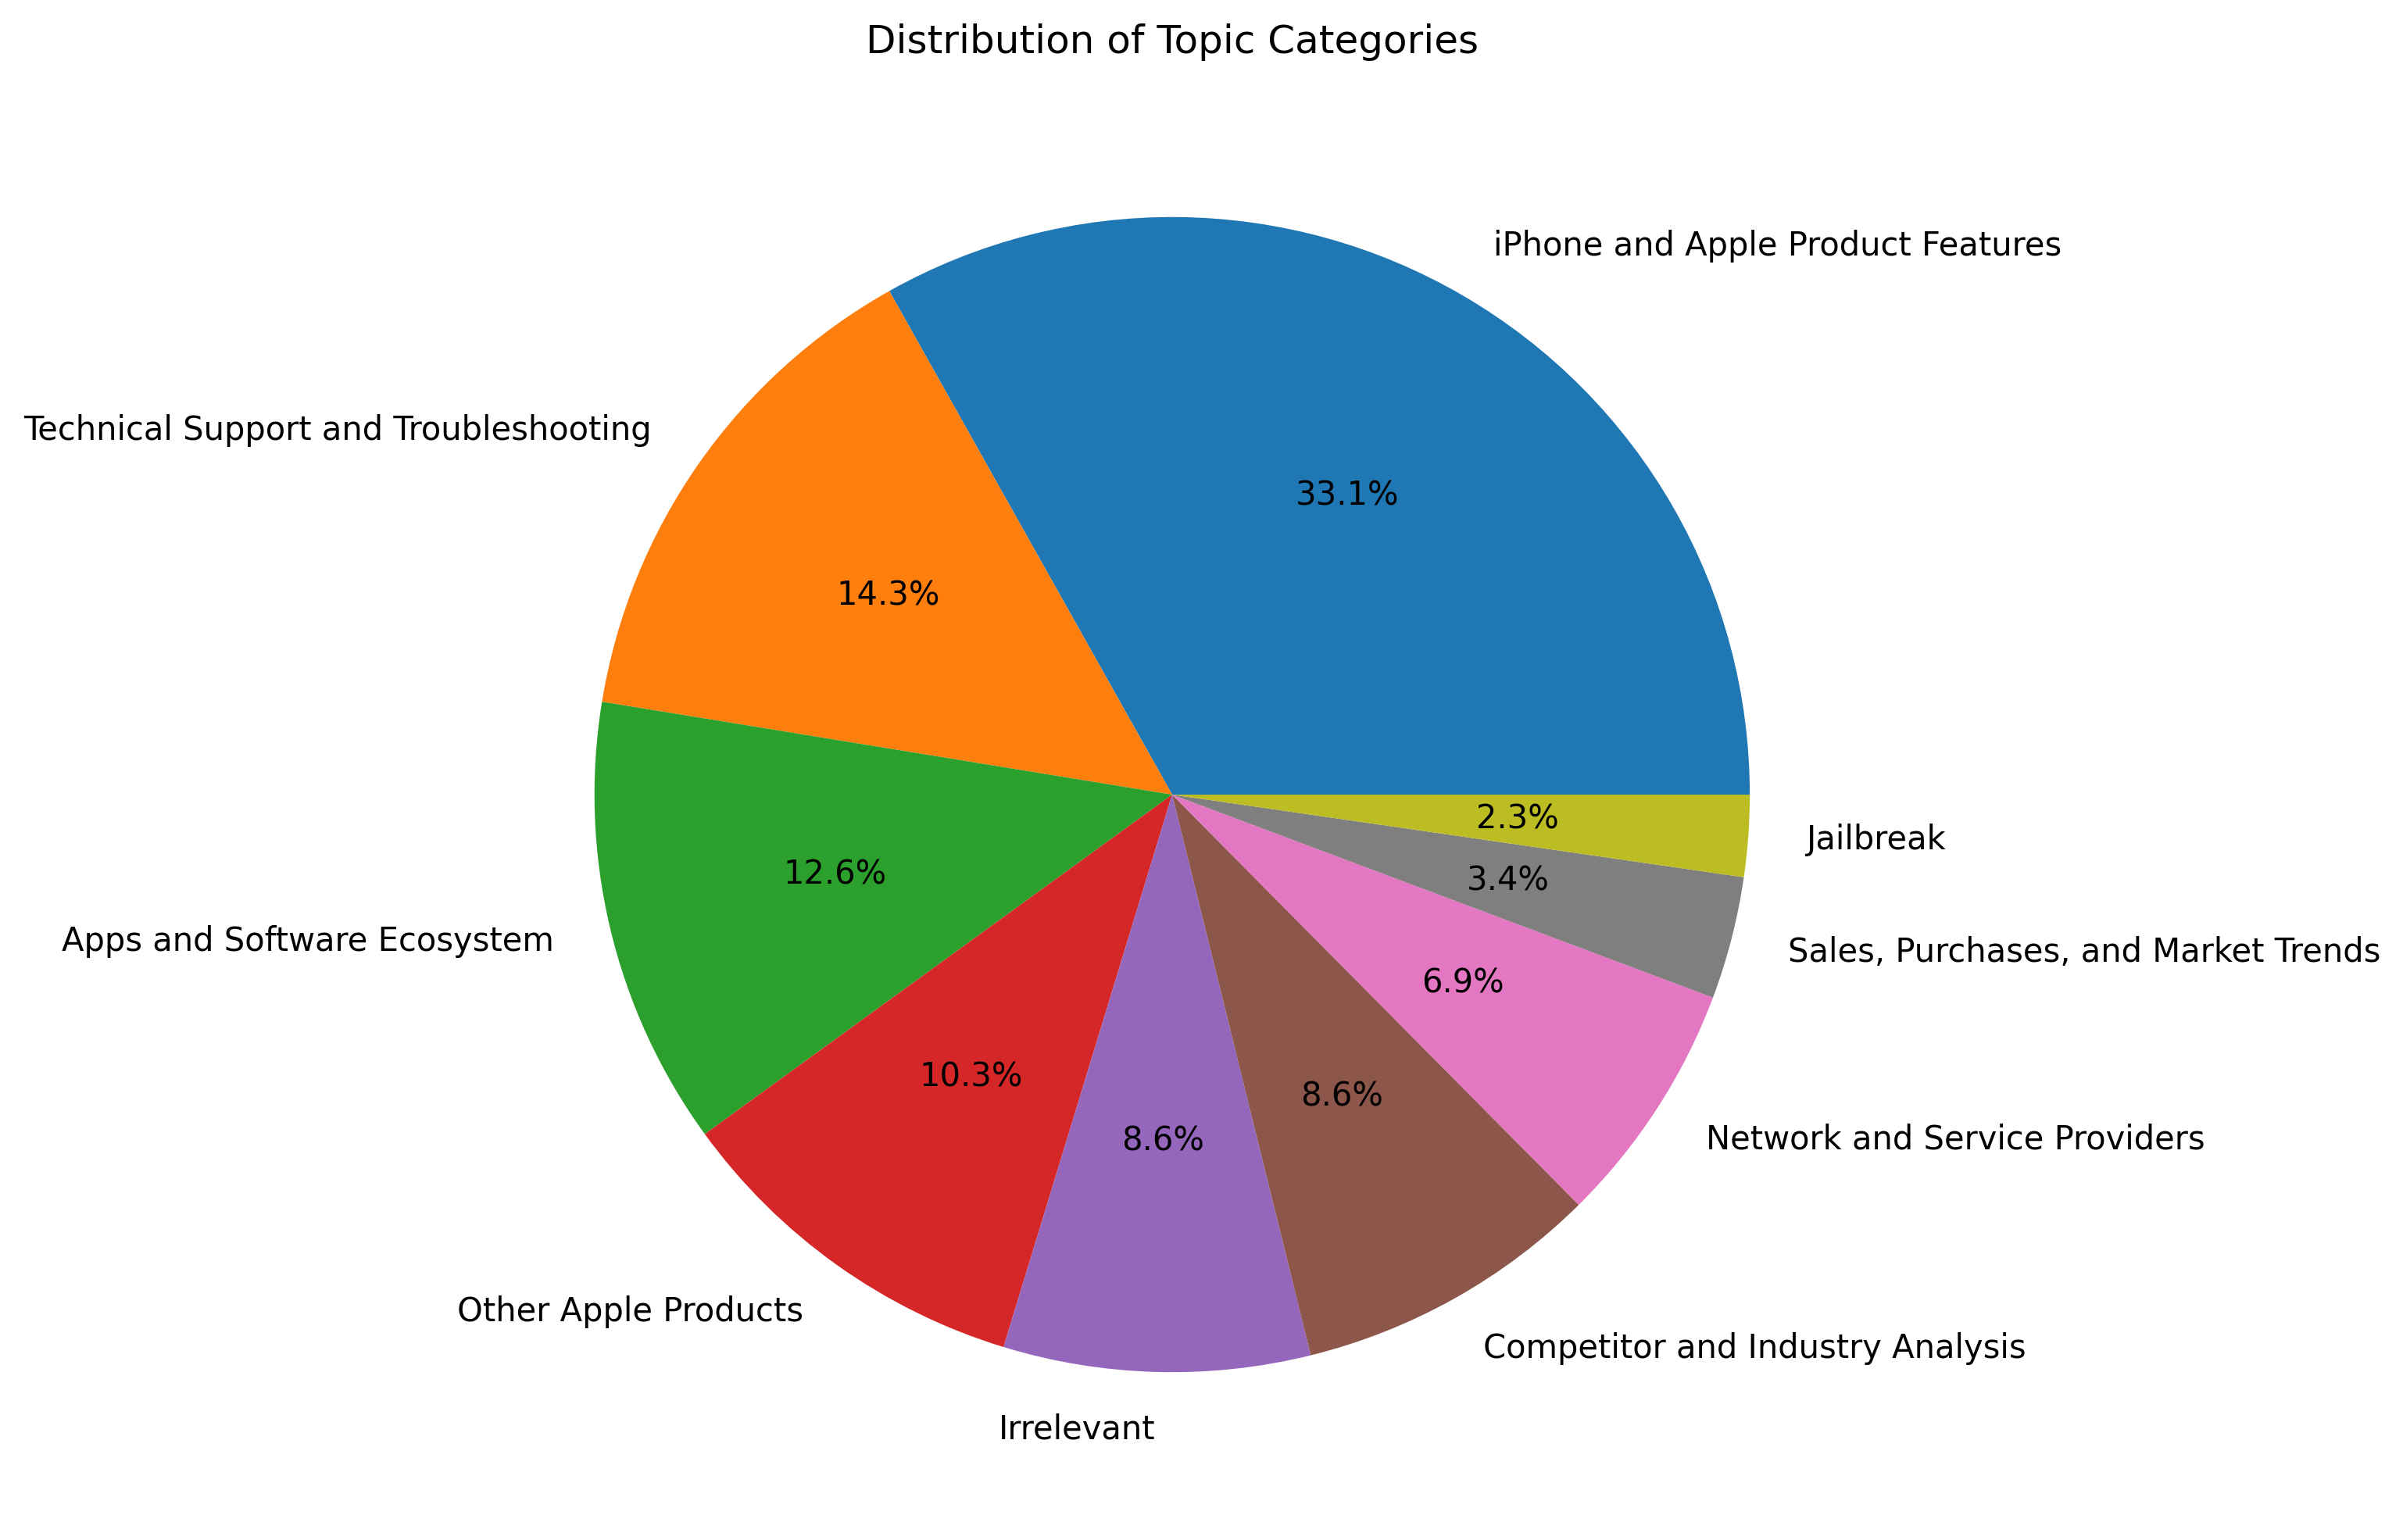

In [25]:
def plot_pie(save_path=None, high_res=False):
    """
    Generates a pie chart showing the distribution of topic categories.
    Optionally, saves the plot to a specified path in high resolution.
    
    :param save_path: String, file path where the plot will be saved. If None, plot is not saved.
    :param high_res: Boolean, if True, the plot will be generated in high resolution.
    """
    
    df = pd.read_csv('./data/topics_iphone_v2.csv', header=0, sep=';')
    df.topic_category = df.topic_category.apply(lambda x: str(x).strip())
    
    # Counting the occurrences of each category
    category_counts = df['topic_category'].value_counts().to_dict()

    # Set the DPI for higher resolution
    dpi = 300 if high_res else 100  # You can adjust the DPI as needed

    # Create a figure and axis for the pie chart
    fig, ax = plt.subplots(figsize=(10, 8), dpi=dpi)

    # Create a pie chart
    ax.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%')
    ax.set_title('Distribution of Topic Categories')

    # Save the figure if a save path is provided
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    return fig

fig = plot_pie(save_path='./dist_topic_cates.png', high_res=True)
plt.show(fig)

In [26]:
def show_topic(year, topic_num ):
    """
    """
    vec, dtm, model = pickle.load(f'./data/lda_model_{year}_v2_dtm.pkl')
    
def display_topics(model, feature_names, no_top_words, save_path = ''):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d:" % (topic_idx)] = ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        
    if save_path != '':
        with open(save_path, 'w') as file:
            for topic, words in topic_dict.items():
                file.write(f"{topic} {words}\n")
        
    return topic_dict

In [27]:
# keywords are extracted from the Appendix A, and then they are filter using GPT to have a more concise result.
keywords_2008 = ['iPod', 'iPod Touch', '3G', 'iTunes', 'Battery Life', 'AT&T', 'Safari', 'Microsoft', 'Flash', 'Steve Jobs', 'Protector',
                'YouTube']

hot_events_2008 = {'3G'}

keywords_2009 = [ 'Snow Leopard', 'Jailbreak', '3G', '3GS', 'Battery Life', 'Battery Life', 'MacBook', 'iPod Touch', 
                 'iTunes', 'iPod', 'AT&T', 'Verizon', 'Steve Jobs', 'Android', 'Contract', 'Protector', 'Warranty', 'Safari',
                'YouTube']

hot_events_2009 = {'3GS'}

keywords_2010 = ['Snow Leopard', 'OSX', 'iPod Touch', 'Battery Life', 'WiFi', 'Facetime', 'Antenna', 'Signal', 'Bumper', 'Design', 
                 'Jailbreak', 'iOS4', 'iPad', 'Resolution', 'HD', 'Flash', 'Safari', 'HTML5', 'Android', 'Competition', 
                 'Microsoft', 'iTunes', 'Streaming', 'Netflix', 'Verizon', 'T-mobile', 'AT&T', 'Contract', 'Protector', 'AppleCare',
                'YouTube', 'Chrome']

hot_events_2010 = {'Antenna', 'Signal', 'Bumper', 'Snow Leopard', 'Flash', 'HTML5'}

keywords_2011 = ['iTunes', 'Facebook', 'YouTube', 'Streaming', 'Netflix', 'Safari', 'UI', 'Gestures', 'Swipe', 'Scroll',
                'Warranty', 'AppleCare', 'Battery Life', 'Siri', '4G',
                'iCloud', 'iOS5', 'Restore', 'iPad', 'Resolution', 'Consumer', 'MacBook', 'Lion OS X', 'Upgrade',
                'Android', 'Google', 'Samsung', 'Competition', 'Steve Jobs', 'Microsoft', '3G', '4G',
                'Legacy', 'Impact', 'Innovation', 'Verizon', 'AT&T', 'Contract', 'Protector', 'Jailbreak', 'Chrome', 'Camera']

hot_events_2011 = {'Steve Jobs', 'Legacy', 'Impact', 'Innovation', 'iCloud', 'iOS5', 'Lion OS X', 'Gestures'}

keywords_2012 = ['Google Maps', 'Siri', 'iOS6', 'Connector', 'Dock', 'Headphone Jack', 'Samsung', 
                 'Patent', 'Lawsuit', 'Battery Life', 'WiFi', 'Bluetooth', 'iCloud', 'iTunes', 'Streaming', 'Siri', 
                 'MacBook', 'Lion OS X', 'Graphics Performance', 'Jailbreak', 'Safari', 'Chrome', 
                 'Resolution', 'Camera', 'Consumer Response', 'Tech Community Discussions', 'AT&T', 'Verizon', '3G', '4G', 'LTE', 'Sprint', 
                 'Contract', 'T-mobile', 'Protector', 'Warranty', 'AppleCare', 'iMessage', 'YouTube', 'Adapter', 'Facebook']

hot_events_2012 = {'Samsung', 'Patent', 'Lawsuit', 'Graphics Performance', 'iPad Size', 'iMessage'}

keywords_2013 = ['Siri', 'iOS6', 'USB', 'Connector', 'Dock', 'Samsung', 'Patent', 'Lawsuit', 
                 'Battery Life', 'WiFi', 'Bluetooth', 'iTunes', 'iCloud', 'Streaming', 'Siri', 'Camera', 'Photo', 'MacBook', 'Lion OS X', 
                 'Performance', 'Jailbreak', 'Safari', 'iPad', 'Resolution', 'Camera', 'Tech Community Discussions', 'iOS 7',
                 'UI', 'Design', 'Apple Maps', 'Google Maps', 'Errors', 'Inaccuracies', 'AT&T', 'Verizon', '3G', '4G', 'LTE', 
                 'Sprint', 'Contract', 'Protector', 'T-mobile', 'Warranty', 'AppleCare', 'iMessage', 'YouTube', 'Chrome', 'Facebook']

hot_events_2013 = {'LTE', '4G', 'iOS 7', 'Design', 'UI', 'USB', 'Connector', 'Dock', 'Google Maps', 'Apple Map', 'Inaccuracies'}

keywords_2014 = ['Bendgate', 'Durability', 'Design', 'Launch', 'Anticipation', 'Preorders', 'Delivery', 'NFC', 'Credit Card', 'Payment',
                'Security', 'Apple Pay', 'Fingerprint', 'Tap-to-Pay', 'Upgrade', 'Storage Capacity', 'MacBook', 'Performance',
                'Google Maps', 'Siri', 'iTunes', 'Samsung', 'Android', 'Camera', 'iCloud', 'Battery Life', 'Lion OS X', 'Jailbreak',
                'WiFi', 'Cellular Technologies', 'iPhone 6', 'AT&T', 'Verizon', '3G', 'Sprint', 'Contract', 'LTE', 'Gold', 'Protector',
                'T-mobile', 'Expensive', 'Warranty', 'AppleCare', 'iMessage', 'Safari', 'Spotify', 'YouTube', 'Chrome', 'Facebook']

hot_events_2014 = {'Bendgate', 'Durability', 'Design', 'Launch', 'Anticipation', 'Preorders', 'Delivery', 'NFC', 'Credit Card', 'Payment',
                'Security', 'Apple Pay', 'Fingerprint', 'Tap-to-Pay', 'Gold'}

keywords_2015 = ['Apple Watch', '3D Touch', 'Sport', 'Spotify', 'iTunes', 'Google Maps', 'Gmail', 'Siri', 'iCloud', 'Samsung', 
                 'Galaxy', 'Design', 'Ecosystem', 'USB-C', 'Camera', 'Battery Life', 'MacBook', 'iPad', 'Streaming', 'Privacy', 'Security',
                'Jailbreak', 'Force Touch', 'UI', 'iPhone 6s', 'Storage Capacity', '4K', 'Resolution', 'Market Trends', 'Consumer', 'Industry', 
                 'Sales', 'AT&T', 'Verizon', 'LTE', 'Sprint', 'Contract', 'Student' 'SSD', 'Comparison', 'UI', 'Force Touch',
                'Battery Life', 'Low-light', 'Protector', 'T-mobile', 'Expensive', 'Warranty', 'AppleCare', 'iMessage', 'Performance',
                'Safari', 'YouTube', 'Chrome', 'Adapter', 'Facebook']

hot_events_2015 = {'Apple Watch', '3D Touch', 'Sport', 'Samsung', 'Galaxy', 'Design', 'Ecosystem', 'Force Touch', 'UI', 'iPhone 6s'}

keywords_2016 = ['SSD', 'GPU', 'Security', 'Law', 'Unlock', 'Privacy', 'Apple Watch', 'Rumor', 'Keynote', 'Headphone Jack', 'Fingerprint',
                 'Touch Bar', 'MacBook Pro', 'SSD', 'GPU', 'Performance', 'Bluetooth', 'AirPods', 'Wireless', 'Audio', 'Android', 
                 'Samsung', 'Google', 'Nexus', 'Galaxy S7', 'AT&T', 'Verizon', 'LTE', 'Sprint', 'Contract',
                'USB-C', 'Camera', '3D Touch', 'Force Touch', 'Sensor', 'iPad', 'Surface', 'Microsoft', 'macOS', 'MacBook',
                 'Professional', 'Battery Life', '4K', 'Resolution', 'Battery Life', 'Low-light', 'Protector', 'T-mobile',
                'Tim Cook', 'Jailbreak', 'Warranty', 'AppleCare', 'iMessage', 'Safari', 'Spotify', 'YouTube', 'Chrome', 'Facebook']

hot_events_2016 = {'SSD', 'GPU', 'Security', 'Law', 'Unlock', 'Privacy', 'Apple Watch', 'Rumor', 'Headphone Jack', 'Touch Bar',
                  'AirPods', 'Wireless', 'Audio', 'Samsung', 'Galaxy S7', 'Low-light'}

keywords_2017 = ['iOS 11', 'iCloud', 'iTunes', 'MacBook', 'Upgrade', 'Android', 'Google', 'Camera', 'iPad', 'Siri', 'Voice', 
                 'Bluetooth', 'Ecosystem', 'Performance', 'Face ID', 'Touch ID', 'Unlock', 'Security', 'Biometrics', 
                 'RAM', 'CPU', 'Touch Bar', 'Smart Keyboard', 'Siri', 'Voice', 'Camera', 'Portrait Mode', 'Low-light', 'Resolution', 
                 'Spotify', 'Streaming', 'iPod', 'Payment', 'Security', 'Tax',
                'WiFi', 'Bluetooth', 'AirPods', 'Wireless', 'Audio', 'Headphone Jack', 'OLED', 'Notch', 'Design', 'Battery Life',
                'Wireless Charging', 'USB-C', 'Charger', 'Adapter', 'Protector', 'AT&T', 'Verizon', 
                 'Sprint', 'Contract', 'T-mobile', 'iPhone SE', 'size', 'Usability', 'Expensive', 'Flagship', 'Jailbreak', 'Warranty',
                'AppleCare', 'iMessage', 'Safari', 'YouTube', 'Chrome', 'Facebook']

hot_events_2017 = {'iOS 11', 'Face ID', 'Security', 'Biometrics', 'OLED', 'Notch', 'Design', 'Wireless Charging'}

keywords_2018 = [ "Android", "Google", "iPad", "MacBook", "WiFi", "LTE", "Cellular", "Camera", "iCloud", "iTunes", "Siri", 
                 "Voice", "Battery Life", "AirPods", "Wireless", "Audio", "3D Touch", "UI", "Payment", 
                 "Security", "NFC", "USB-C", "Wireless Charging", "Consumer Behavior", "Market Trends", "MacBook", "Performance", 
                 "RAM", "CPU", "Headphone Jack", "Bluetooth", "Privacy", 'Portrait Mode', 'Low-light',
                 'Student', 'iPod', 'Surface', 'iOS 11', 'iOS 12', 'Spotify', 'HomePod', 'OLED', 'LCD', 'Pixel', 'Resolution',
                 'iPhone XR', 'USB-C', 'Wireless', 'Adapter', 'Tim Cook', 'Expensive', 'Sales', 'Upgrade'
                'macOS', 'Streaming', 'Design', 'Notch', 'Android', 'Samsung', 'Jailbreak', 'Verizon', 'T-mobile', 'Protector', 'Warranty',
                'AppleCare', 'iMessage', 'Safari', 'YouTube', 'Chrome', 'Facebook']

hot_events_2018 = {'iOS 12', 'HomePod', 'OLED', 'LCD', 'Pixel', 'iPhone XR', 'Design', 'Notch'}

keywords_2019 = ['Android', 'Samsung', 'Google', 'Pixel', 'Galaxy', 'Ecosystem', 'WhatsApp', 'Security', 'Flagship', 'Camera', 
                 'UI',  '3D Touch', 'Face ID', 'Fingerprint', 'Unlock', 'Battery Life', 'Resolution', 'True Tone', 'iOS 11', 
                 'Upgrade', 'iPhone SE', 'iPhone XR', 'Storage', 'Durability', 'Credit Card', 'Payment', 'Privacy',
                 'Siri', 'AirPods', 'Wireless', 'Audio', 'USB-C', 'Notch', 'Design', 'WiFi', 'Bluetooth', 'MacBook', 'Performance', 'Chip', 
                 'Intel', 'China', 'Market Trends', 'Profit', 'Tim Cook', 'Law', 'Government', 'Streaming', 'Spotify', 'Netflix', 
                 'Safari', 'Jailbreak', 'Verizon', 'LTE', 'Protector', 'Warranty', 'AppleCare', 'iMessage', 'YouTube', 'Chrome',
                'Adapter', 'Facebook', 'Apple Watch', 'iPod Touch']

hot_events_2019 = {'Camera', 'China', 'Market Trends', 'Profit', 'Apple Watch', 'iPod Touch', 'Government'}

def is_hot_event(word, event_list):
    if word in event_list:
        return(True)
    else:
        return(False)


test_data = []

for x in keywords_2008:
    temp_dict = {}
    temp_dict['year'] = 2008
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2008):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)

for x in keywords_2009:
    temp_dict = {}
    temp_dict['year'] = 2009
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2009):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2010:
    temp_dict = {}
    temp_dict['year'] = 2010
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2010):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)

for x in keywords_2011:
    temp_dict = {}
    temp_dict['year'] = 2011
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2011):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2012:
    temp_dict = {}
    temp_dict['year'] = 2012
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2012):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2013:
    temp_dict = {}
    temp_dict['year'] = 2013
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2013):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2014:
    temp_dict = {}
    temp_dict['year'] = 2014
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2014):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2015:
    temp_dict = {}
    temp_dict['year'] = 2015
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2015):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2016:
    temp_dict = {}
    temp_dict['year'] = 2016
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2016):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)
    
for x in keywords_2017:
    temp_dict = {}
    temp_dict['year'] = 2017
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2017):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)

for x in keywords_2018:
    temp_dict = {}
    temp_dict['year'] = 2018
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2018):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)

for x in keywords_2019:
    temp_dict = {}
    temp_dict['year'] = 2019
    temp_dict['keyword'] = x
    if is_hot_event(x, hot_events_2019):
        temp_dict['hot_event'] = True
    else:
        temp_dict['hot_event'] = False
    test_data.append(temp_dict)


data = pd.DataFrame(test_data)

# 创建图表
chart = alt.Chart(data).mark_circle(size=60).encode(
    x='year:O',
    y='keyword:N',
    color=alt.Color('hot_event:N', legend=alt.Legend(title='Align with hot event'))
).properties(
    title='Yearly Key iPhone Topics and Their Alignment with Reality',
    width=600,
    height=1490
)

In [28]:
chart

alt.Chart(...)